In [1]:
## DBSCAN: Density Based Spatial Clustering of Applications with Noise
# 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있어, 복잡한 기하학적 분포도를 가진 데이터 세트에 효과적
# 군집 개수 지정 불가
# 핵심포인트, 이웃포인트, 경계포인트, 잡음포인트
# 핵심포인트끼리 이동하면서 잡음포인트 날려버리는 방식으로 군집화를 수행

# DBSCAN_iris
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target
irisDF.head()


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [2]:
# eps 0.6 min_samples=8 로 DBSCAN 군집화 적용
# 참고로 eps는 원의 크기니까 올리면 노이즈가 줄어들고
# min_samples는 포인트 판정시 필요한 최소 샘플 개수니까 조건을 올리면 제한이 심해지니 노이즈가 늘어난다

# 결과 기준으로 -1은 노이즈, 0이랑 1은 군집 넘버링이라고 생각하면 된다. 

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)


target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


In [3]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

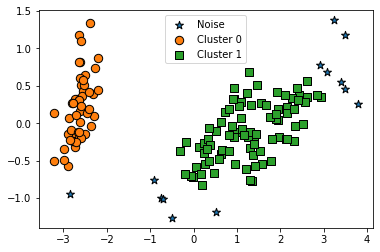

In [6]:
# PCA 2개 컴포넌트로 차원 축소 후 시각화
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)

irisDF['ftr1'] = pca_transformed[:, 0]
irisDF['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


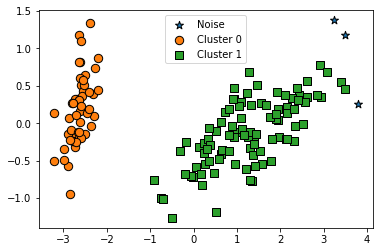

In [7]:
# case1) eps 크기를 증가시키는 경우, 노이즈가 줄어든다(많이 포함된다)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: dbscan_cluster, dtype: int64


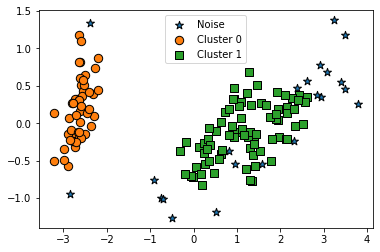

In [8]:
# case2) min_samples 크기를 증가시키는 경우, 노이즈가 늘어난다(적게 포함된다)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

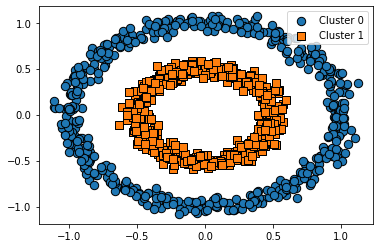

In [9]:
# 추가예제, make_circles() dataset
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

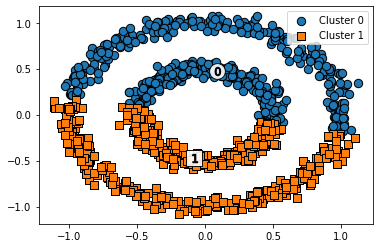

In [11]:
# Case1: KMeans 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

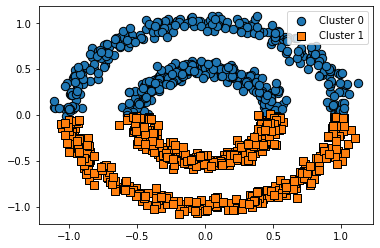

In [20]:
# case2: GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit_predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)


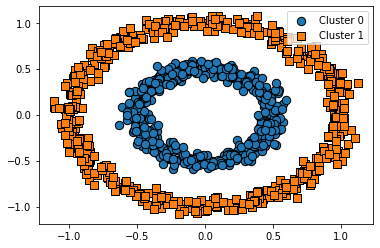

In [24]:
# case3: DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_label = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_label

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)